In [3]:
!pip install transformers datasets torch

transformers를 import 해서 Hugging Face 모델/토크나이저 사용을 해주겠다.


In [3]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import psutil
import time
import numpy as np

psutil: 메모리 사용량 측정 해 주기 위해 import
GPT2Model을 import 해 주었다.

그리고 wikitext의 데이터셋을 불러와주겠다.

In [4]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

간단하게 성능확인이 목적이기 때문에 GPT-2 small 버전을 설정해주었다.

GPT2는 기본적으로 padding 토큰을 지원하지 않는다.
일반적인 모델 예를 들면 LSTM,BERT등은 pad_token이 있지만, GPT-2는 eos_token 문장의 끝을 나타내는 토큰만 있기 때문에 eos_token을 대신 사용하도록 설정해주었다.
그리고 사전학습 된 모델을 불러왔다.

In [6]:
def tokenize(examples):
    result = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

    result['labels'] = result['input_ids'].copy()
    return result

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'labels']
)

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

이제, 텍스트 데이터셋을  examples로, 입력받아 tokenizer를 적용시켜주는 함수를 만들어주었다.
이 함수는 데이터에서 text를 가져오고, 지정된 max_length를 초과하면 잘라내는 Truncate를 활성화 시켜주었다.
그 다음 모든 샘플을 max_length만큼 패딩을 해서 동일한 길이로 만들어주었다.
max_length = 128


batched = True 옵션을 통해서 여러 샘플을 한 번에 처리할 수 있도록 했다.
그리고 각 데이터 셋에 map을 해서 각 샘플에 tokenize 함수를 적용해주었다.

그리고 마지막 과정은 데이터를 PyTorch 텐서로 변환을 해서 모델 학습에 용이하도록 했다.

그래서 torch텐서로 변환을 시켜주고, 모델이 필요한 input_ids, attention_mask만 유지시켜주었다.


결국 labels 값이 input_ids와 동일하게 설정됨.

왜 labels를 input_ids의 복사본으로 저장할까?
이 코드는 GPT-2 학습을 위한 코드.
언어 모델은 입력 문장의 다음 단어를 예측하도록 학습한다.
즉, labels을 input_ids의 복사본으로 만들면 출력값이 입력과 동일한 구조를 가지도록 설정할 수 있겠다.

그리고 라벨링도 진행해주었다.


In [7]:
training_args = TrainingArguments(
   output_dir="./gpt2-base",
   num_train_epochs=1,
   per_device_train_batch_size=16,
   save_steps=10_000,
   logging_steps=100,
)

이제 이 TrainingArguments들을 설정해준다.
하이퍼 파라미터들을 설정해줬다.
아까 배웠던 HuggingFace의 Trainer API를 참고하여 설정해주었다.

이 설정들은 모델을 학습할 때 사용해 줄 것이다.



전체 데이터 셋을 한 번 학습하는 Epoch는 1로 설정을 해주었다.

그리고 한 장치 당 학습 스텝에서의 샘플 개수는 16으로 해주었다.

이게 우리가 이번에 논하는 batch_size가 되겠다.

batch_size 한 번 마다 step은 10,000 스텝마다 체크포인트를 저장해주었다.

이게 무슨 말이냐면, 만약 batch_size 가 16이고 데이터 셋이 8만개라고 가정을 해 보자.

80000 / 16 = 5000

5000스텝이 한 에폭에 해당하는 것이다.

로그는 100스텝마다.

In [8]:
def get_memory_usage():
  return psutil.Process().memory_info().rss / 1024 / 1024

현재 실행중인 프로세스를 가져오고,
memory_info() → 현재 프로세스의 메모리 사용량을 반환하는 메서드
.rss (Resident Set Size) → RAM에서 현재 프로세스가 실제로 차지하고 있는 메모리 크기 (바이트 단위)

RSS (Resident Set Size)란?

운영체제에서 특정 프로세스가 물리적 메모리(RAM)에서 실제로 점유하고 있는 크기를 나타냄.
다른 캐시된 메모리나 가상 메모리는 포함되지 않음.

rss는 Byte단위로 반환이 되기 때문에 MB단위로 반환을 해야 한다.
1 KB = 1024 Byte, 1 MB = 1024 KB
메모리 (MB) = 메모리 (바이트) ÷ 1024 ÷ 1024

In [9]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset,
)

아까 설정해준 값들을 Trainer에 준비시킨다.


In [10]:
start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: challengef0802 (songyeog) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
100,1.492100
200,1.392100
300,1.305600
400,1.399200
500,1.276100
600,1.298900
700,1.280000
800,1.220300
900,1.332100
1000,1.306900


TrainOutput(global_step=2295, training_loss=1.2951477117268348, metrics={'train_runtime': 292.2833, 'train_samples_per_second': 125.625, 'train_steps_per_second': 7.852, 'total_flos': 2398530207744000.0, 'train_loss': 1.2951477117268348, 'epoch': 1.0})

In [11]:
end_time = time.time()
final_memory = get_memory_usage()

In [12]:
print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Memory usage: {final_memory - initial_memory:.2f} MB")

Training time: 292.64 seconds
Memory usage: 406.14 MB


경과 시간과 증가한 메모리 사용량을 출력

얼마나 많은 메모리가 사용이 되었는지 알 수 있도록.

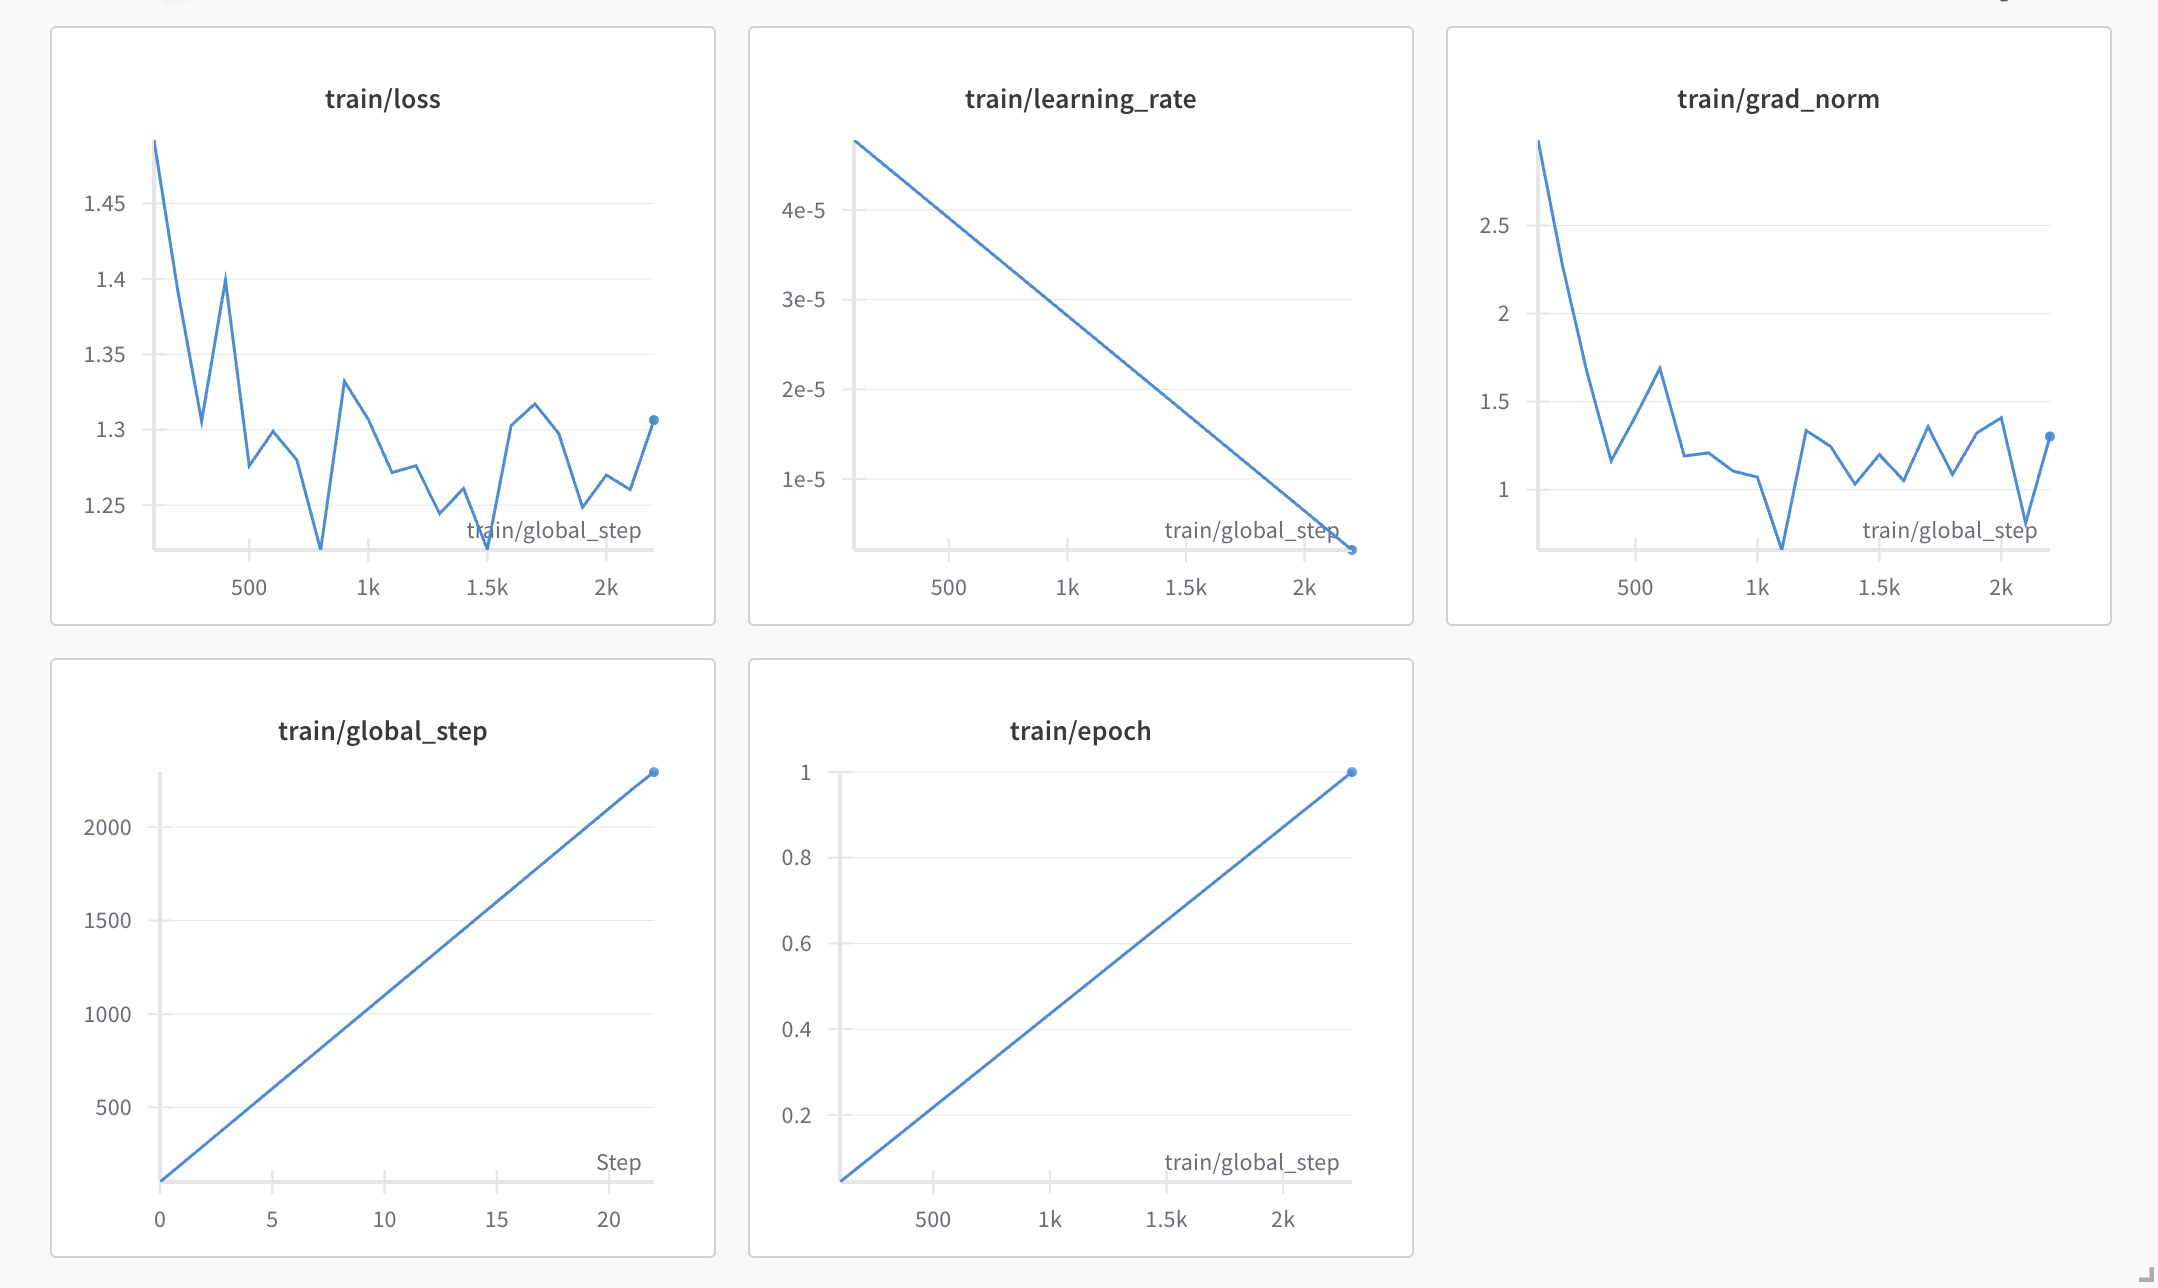

# - Wandb 그래프 추이



# 이제 Gradient Accumulation을 적용해보자! feat. accelerate

문서에서 설명하고 있는 것 처럼, acceerate를 적용해서 gradientAccumulation을 진행해보겠다.

In [1]:
!pip install transformers datasets torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import psutil
import time
from accelerate import Accelerator

In [10]:
accelerator = Accelerator()

In [11]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [12]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [13]:
def tokenize(examples):
    result = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    result['labels'] = result['input_ids'].copy()
    return result


In [14]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [28]:
pip install wandb

In [29]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: challengef0802 (songyeog) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [31]:
training_args = TrainingArguments(
    output_dir="./gpt2-accelerate",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    save_steps=10_000,
    logging_steps=100,
    report_to="wandb",
    run_name="gpt2-fineTuning"
)

각 GPU에서 4개의 샘플들을 처리하고 4 스탭동안 누적을 하기 때문에 배치 크기를 위와 같이 16처럼 설정한 효과를 내어 주기를 기대하고 설정해주었다.


In [32]:
def get_memory_usage():
    return psutil.Process().memory_info().rss / 1024 / 1024

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

accelerator 로 래핑을 해 준다.

In [34]:
model, trainer = accelerator.prepare(model, trainer)

In [35]:
start_time = time.time()
initial_memory = get_memory_usage()

In [36]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
100,1.112300
200,1.176400
300,1.109000
400,1.202600
500,1.103600
600,1.137400
700,1.135900
800,1.089600
900,1.202700
1000,1.189800


TrainOutput(global_step=2295, training_loss=1.183423240512025, metrics={'train_runtime': 385.595, 'train_samples_per_second': 95.224, 'train_steps_per_second': 5.952, 'total_flos': 2398530207744000.0, 'train_loss': 1.183423240512025, 'epoch': 1.0})

In [37]:
end_time = time.time()
final_memory = get_memory_usage()

In [38]:
print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Memory usage: {final_memory - initial_memory:.2f} MB")

Training time: 386.16 seconds
Memory usage: 8.21 MB


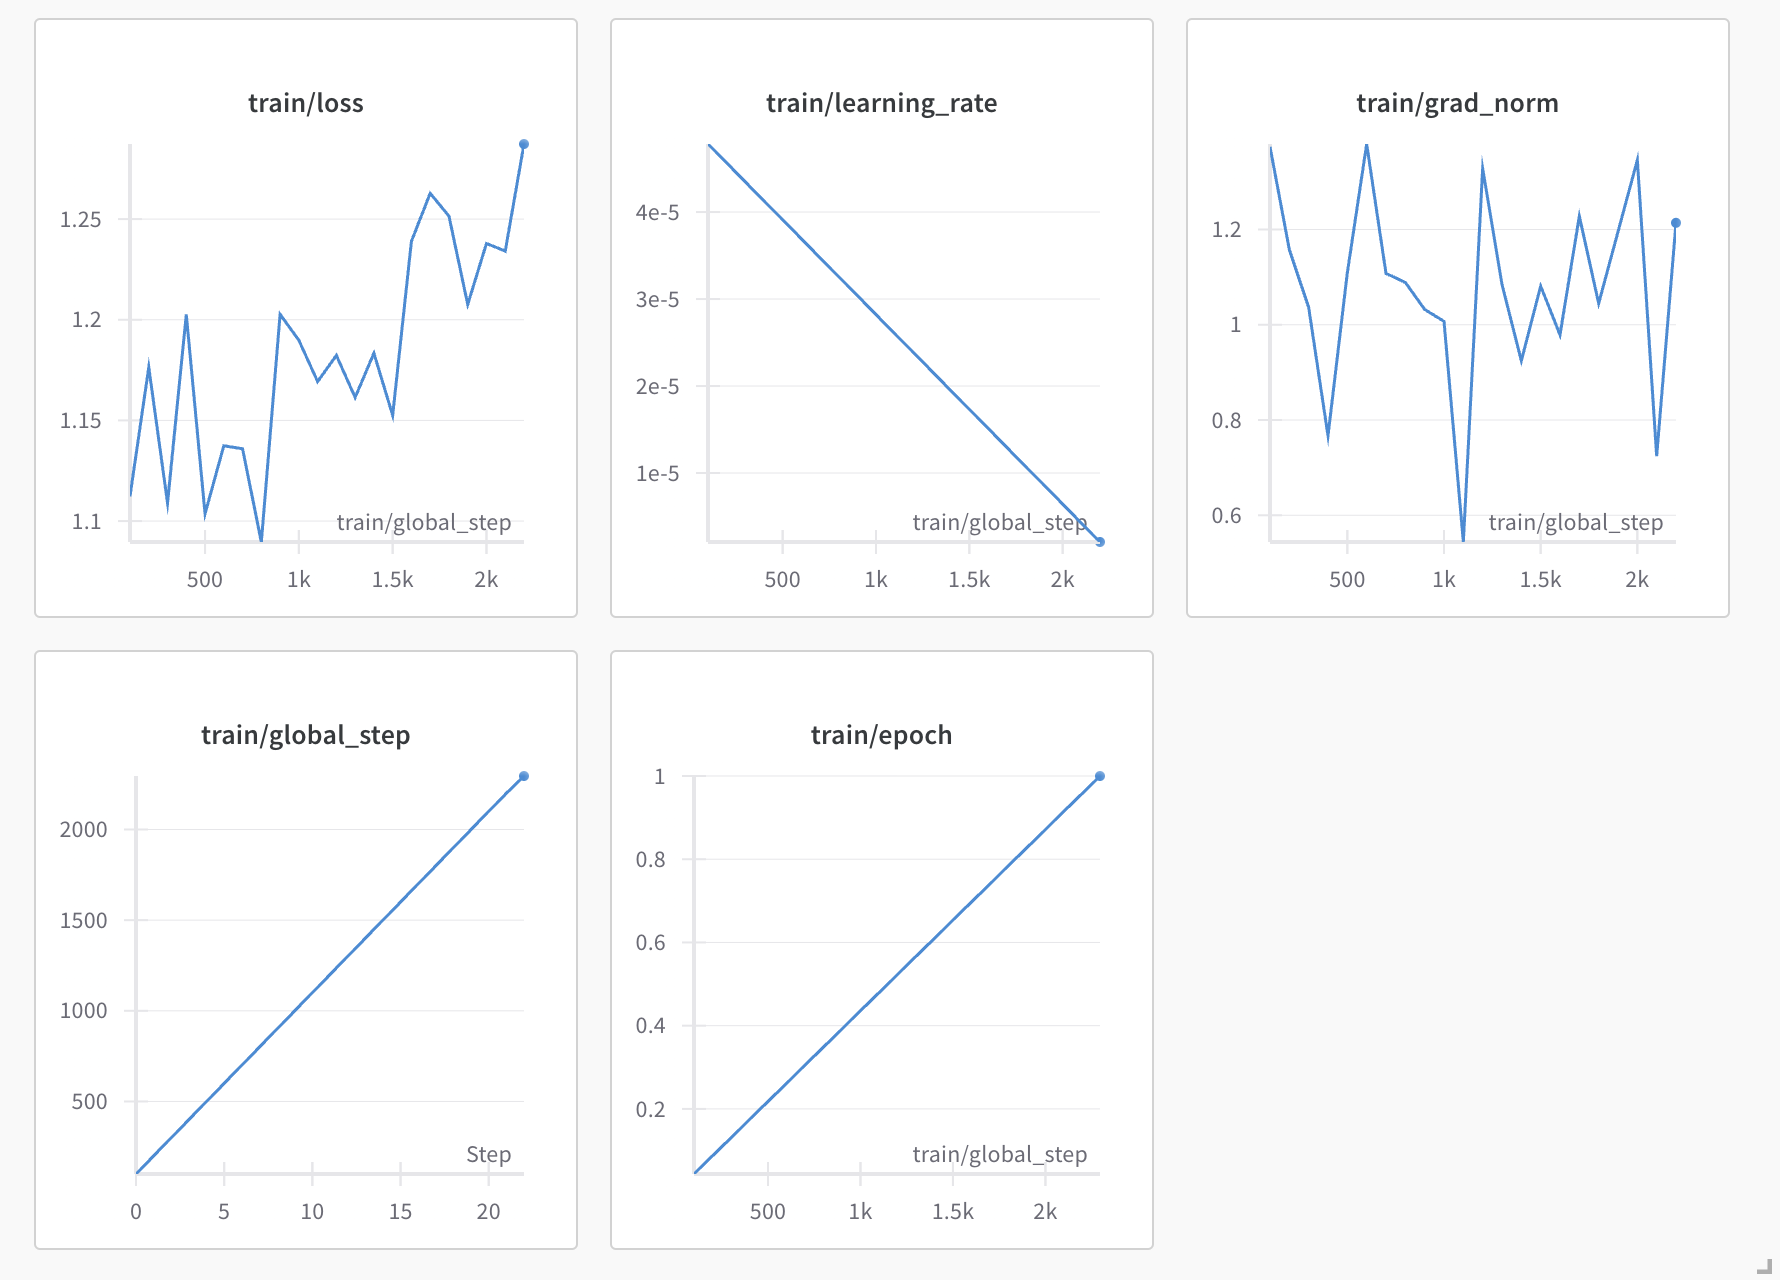

메모리 사용량은 정말 눈에 띄게 줄어들었고,

학습시간은 약간 증가한 모습이다.

이는 더 자주 forward-pass를 진행해서 그렇다고 판단했다.

### 결론 : 학습 시간이 조금 더 걸리더라도, 메모리 부족 문제를 해결해 줄 수 있겠다!


## 그래프 비교 해석 feat.wandb

### **Gradient Accumulation을 적용했을 때 (왼쪽)**

- **훈련 손실이 더 불안정**함 → 업데이트가 덜 자주 이루어지기 때문.
- **그래디언트 norm이 급격히 변화** → 누적된 그래디언트를 한 번에 업데이트하면서 발생.
- **학습률 스케줄은 동일**.

### **Gradient Accumulation을 적용하지 않았을 때 (오른쪽)**

- **훈련 손실이 더 빠르게 감소** → 더 자주 업데이트되기 때문.
- **그래디언트 norm 초반에는 크지만 이후 안정적으로 변함**.
- **학습률 감소 패턴은 동일**.

# Gradient Checkpointing

In [1]:
!pip install transformers datasets torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install transformers datasets torch

In [16]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import psutil
import time
from accelerate import Accelerator

In [17]:
accelerator = Accelerator()

In [18]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

In [19]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2', use_cache=False)  # Gradient Checkpointing을 위해 cache 비활성화
model.gradient_checkpointing_enable()

gradient_chckpointing을 적용해주는  부분이다.

use_cache=True (기본 설정)
Transformer 모델은 디코더(decoder)에서 캐시(cache)를 사용하여 연산을 최적화함.
학습 중에는 이전 단계의 중간 값을 캐싱하여 다시 계산하지 않고 재사용함.
즉, 메모리를 더 사용하지만 학습 속도가 빨라짐.

use_cache=False (Gradient Checkpointing 사용)
Gradient Checkpointing을 사용할 때는 use_cache=False로 설정해야 함.
Gradient Checkpointing은 순전파(Forward Pass) 중 일부 활성화 값을 저장하지 않고, 역전파(Backward Pass) 때 다시 계산하는 기법.
그러나 캐시가 활성화되어 있으면, 역전파 때 다시 계산할 필요가 없어져서 Gradient Checkpointing이 정상적으로 동작하지 않음.
즉, use_cache=False를 설정하면, 매번 활성화 값을 다시 계산하게 되어 Gradient Checkpointing과 함께 동작할 수 있음.

In [20]:
def tokenize(examples):
   result = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
   result['labels'] = result['input_ids'].copy()
   return result

In [21]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [29]:
training_args = TrainingArguments(
   output_dir="./gpt2-checkpointing",
   num_train_epochs=1,
   per_device_train_batch_size=4,
   gradient_accumulation_steps=4,
   gradient_checkpointing=True,  # Gradient Checkpointing 설정
   save_steps=10_000,
   logging_steps=100,
   report_to="wandb",
   run_name="gpt2-gradient_checkpointing",
   log_level="info"
)

In [30]:
def get_memory_usage():
   return psutil.Process().memory_info().rss / 1024 / 1024

In [31]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset,
)


In [32]:
model, trainer = accelerator.prepare(model, trainer)

In [33]:
start_time = time.time()
initial_memory = get_memory_usage()

trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 36,718
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 2,295
  Number of trainable parameters = 124,439,808
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
100,0.962800
200,1.021000
300,0.962100
400,1.057900
500,0.976400
600,1.013700
700,1.024200
800,0.983500
900,1.099900
1000,1.094200


Saving model checkpoint to ./gpt2-checkpointing/checkpoint-2295
Configuration saved in ./gpt2-checkpointing/checkpoint-2295/config.json
Configuration saved in ./gpt2-checkpointing/checkpoint-2295/generation_config.json
Model weights saved in ./gpt2-checkpointing/checkpoint-2295/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2295, training_loss=1.1044172432427832, metrics={'train_runtime': 462.7993, 'train_samples_per_second': 79.339, 'train_steps_per_second': 4.959, 'total_flos': 2398530207744000.0, 'train_loss': 1.1044172432427832, 'epoch': 1.0})

In [34]:
end_time = time.time()
final_memory = get_memory_usage()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Memory usage: {final_memory - initial_memory:.2f} MB")

Training time: 463.19 seconds
Memory usage: -290.82 MB


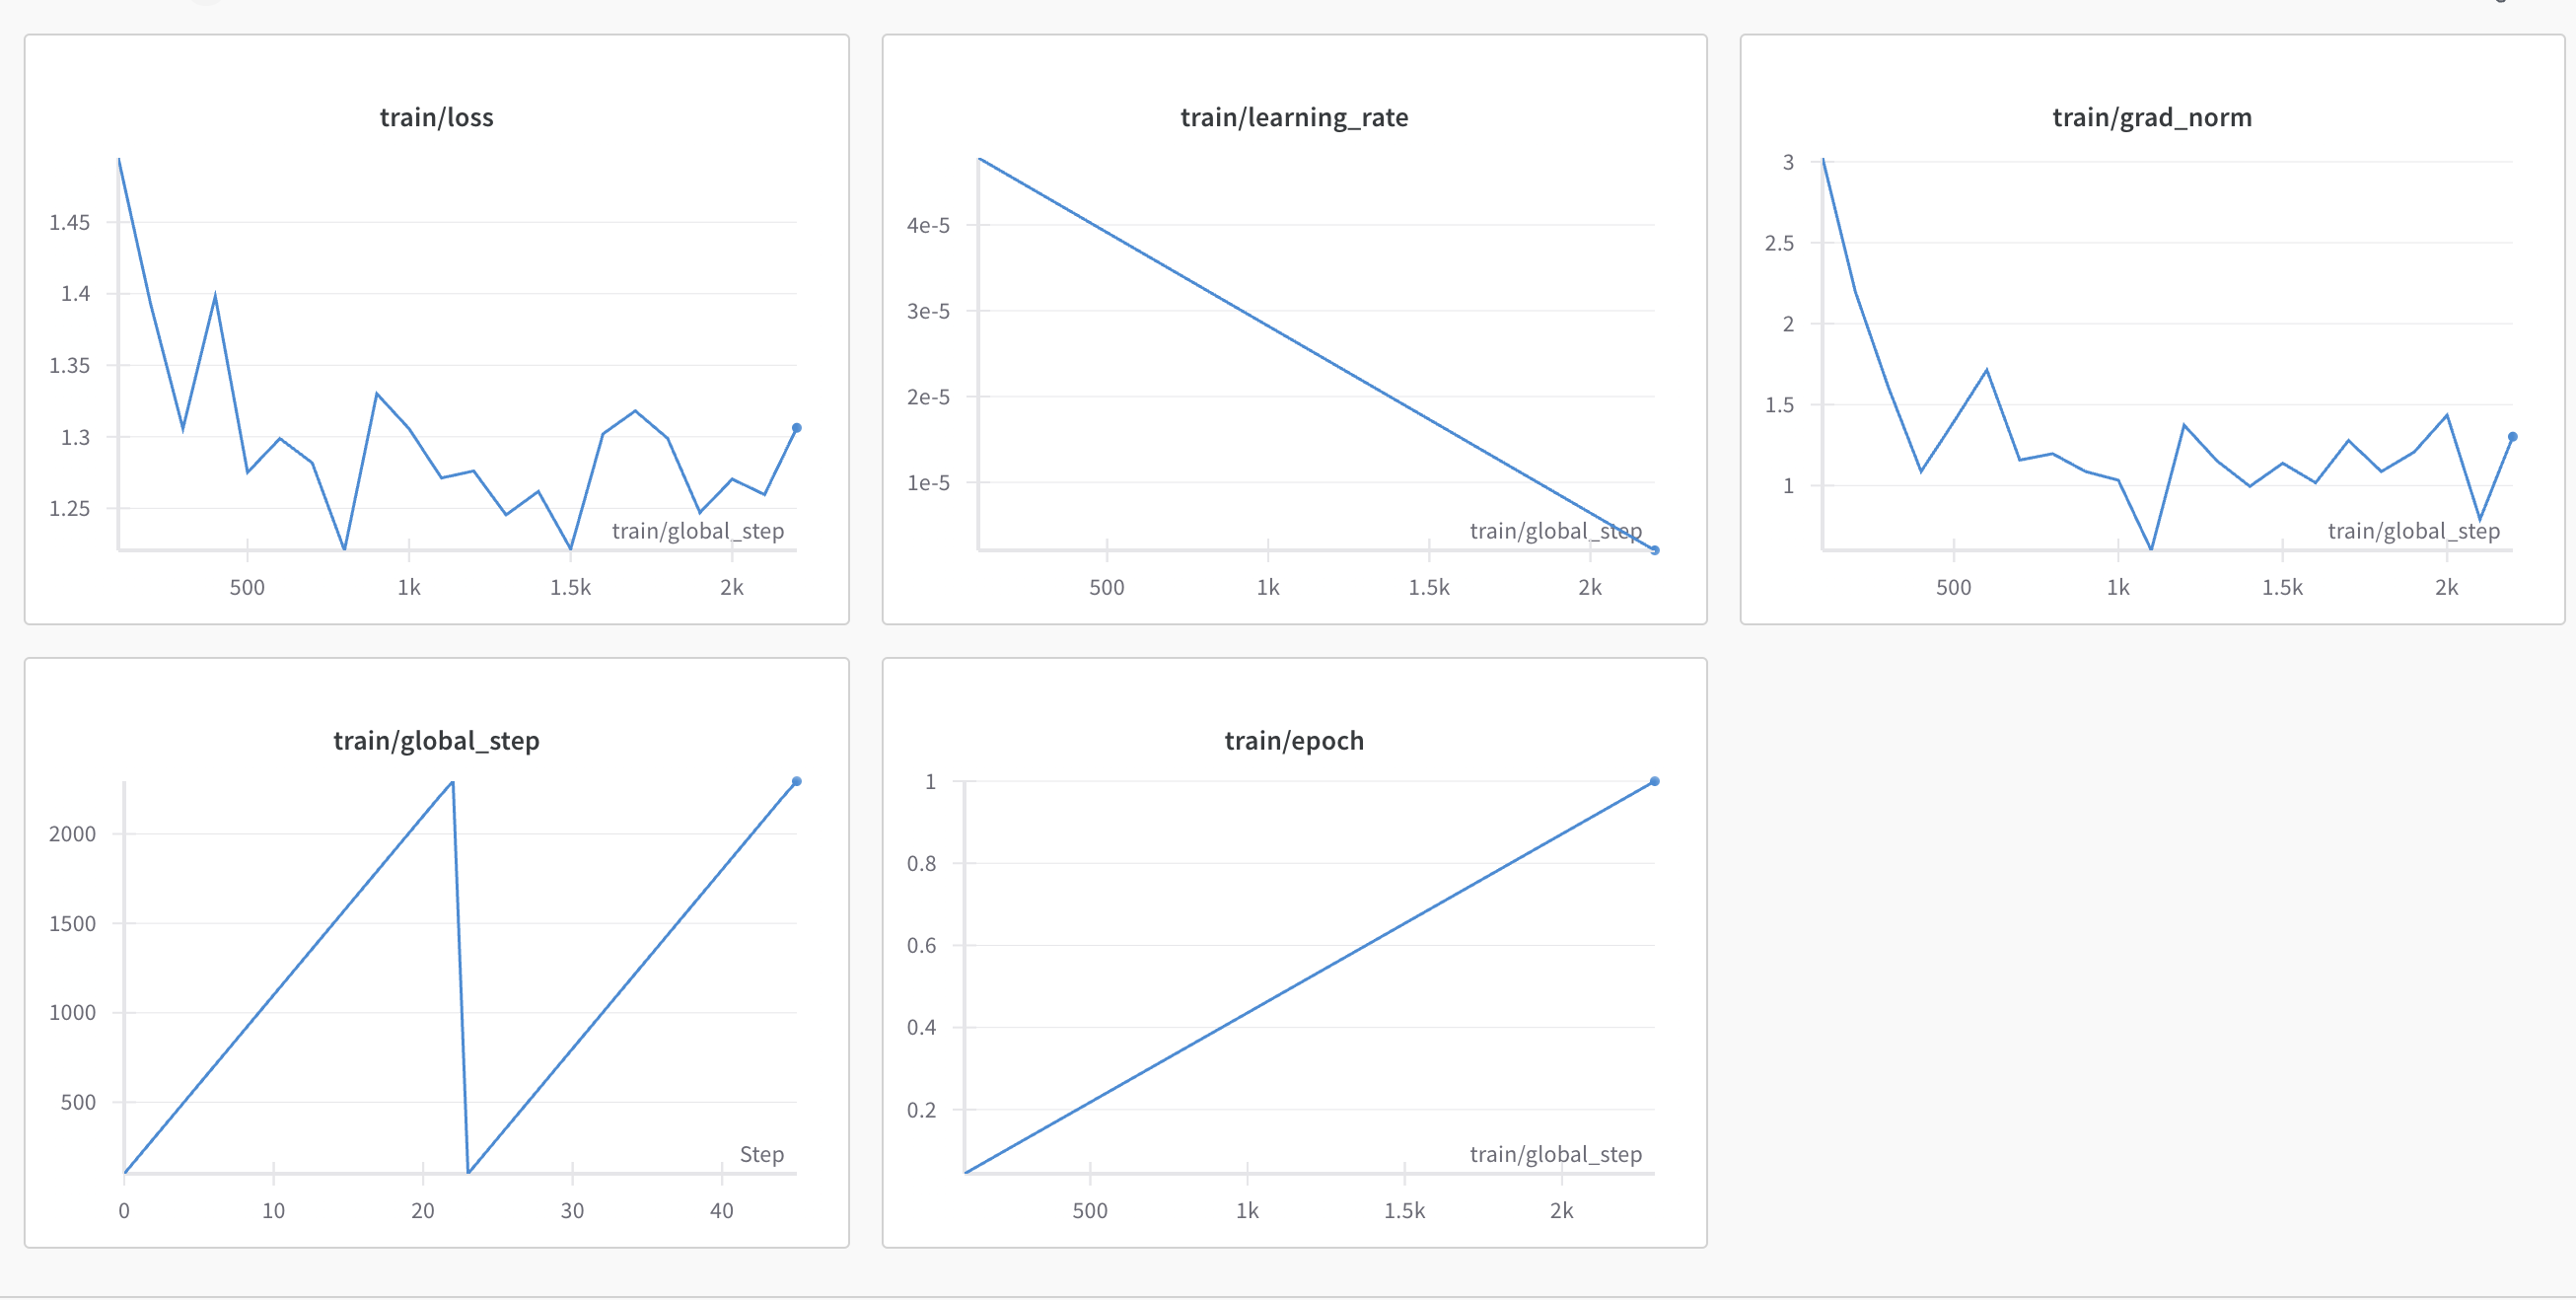

중간에 step을 보니까 훈련이 중단된게 아닌지 의심이 된다 그래서 다시 확인코드를 추가해준다.

In [35]:
import logging

logging.basicConfig(level=logging.INFO)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

model, trainer = accelerator.prepare(model, trainer)

def log_global_step(trainer):
    logging.info(f"Current Global Step: {trainer.state.global_step}")

log_global_step(trainer)

trainer.train()

log_global_step(trainer)


The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 36,718
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 2,295
  Number of trainable parameters = 124,439,808
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
100,0.806000
200,0.858900
300,0.817600
400,0.911600
500,0.844900
600,0.885300
700,0.906100
800,0.870100
900,0.992600
1000,0.993900


Saving model checkpoint to ./gpt2-checkpointing/checkpoint-2295
Configuration saved in ./gpt2-checkpointing/checkpoint-2295/config.json
Configuration saved in ./gpt2-checkpointing/checkpoint-2295/generation_config.json
Model weights saved in ./gpt2-checkpointing/checkpoint-2295/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)




In [36]:
from transformers import TrainerCallback

class GlobalStepLogger(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 100 == 0:
            logging.info(f"Step {state.global_step}: Global Step = {state.global_step}")

trainer.add_callback(GlobalStepLogger())
